# NLP Projection

First map Google drive.

In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

Mounted at /content/drive
Note: using Google CoLab


### Load the Glove Embeddings

In [ ]:
!wget -c "https://nlp.stanford.edu/data/glove.6B.zip"
!unzip /content/glove.6B.zip

--2022-10-05 04:10:28--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-10-05 04:10:29--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  4.23MB/s    in 3m 50s  

2022-10-05 04:14:20 (3.57 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  /content/glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
 

In [ ]:
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

glove_file = '/content/glove.6B.300d.txt'
tmp_file = get_tmpfile("test_word2vec.txt")
_ = glove2word2vec(glove_file, tmp_file)
w2vec_model = KeyedVectors.load_word2vec_format(tmp_file)

### NLP Demo

In [ ]:
w2vec_model.most_similar(positive=['woman', 'king'], negative=['man'])

[('queen', 0.6713277101516724),
 ('princess', 0.5432624220848083),
 ('throne', 0.5386104583740234),
 ('monarch', 0.5347574949264526),
 ('daughter', 0.498025119304657),
 ('mother', 0.4956442713737488),
 ('elizabeth', 0.4832652509212494),
 ('kingdom', 0.47747087478637695),
 ('prince', 0.4668239951133728),
 ('wife', 0.4647327661514282)]

In [ ]:
w2vec_model['dog'].shape

(300,)

### Perform NLP Prediction
Load the three data files.

In [ ]:
import pandas as pd
import os

PATH = "/content/drive/MyDrive/projects/demand/"

df_sales = pd.read_csv("https://data.heatonresearch.com/wustl/CABI/demand-forecast/sales_train.csv", parse_dates=['date'])
df_items = pd.read_csv("https://data.heatonresearch.com/wustl/CABI/demand-forecast/items.csv")
df_resturant = pd.read_csv("https://data.heatonresearch.com/wustl/CABI/demand-forecast/resturants.csv")

In [ ]:
def process_title(model, name):
  v = None
  i = 0
  for word in name.split(' '):
    if word == 'vegi': word = "vegetable"
    if word == 'smoothy': word = "malt"
    i+=1
    if v is None:
      v=model[word].copy()
    else:
      v+=model[word]
  v/=i
  return v

item_lookup = {}
for i, name in zip(list(df_items.id),list(df_items.name)):
  v = process_title(w2vec_model,name)
  item_lookup[i] = v

#r = process_title(model, 'breaded fish with vegetables meal')
print(len(item_lookup))

100


Utility function to create sequences.

In [ ]:
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

Join the items and sales tables so that we can look up the store id for each item.

In [ ]:
df_items2 = df_items[['id','store_id']]
df_train = df_sales.merge(df_items2,left_on='item_id',right_on='id')
df_train[['date','item_id','item_count','store_id']]

df_train = df_train.sort_values('date').groupby(['item_id', 'store_id', 'date'], as_index=False)
df_train = df_train.agg({'item_count':['mean']})
df_train.columns = ['item', 'store', 'date', 'sales']
df_train.head()

,item,store,date,sales
0,1,4,2020-12-01,1.0
1,1,4,2021-10-14,1.0
2,2,4,2020-04-30,1.0
3,2,4,2020-06-09,1.0
4,2,4,2020-12-26,1.0


In [ ]:
df_train['dow'] = df_train['date'].dt.dayofweek
df_train['doy'] = df_train['date'].dt.dayofyear

df_train

,item,store,date,sales,dow,doy
0,1,4,2020-12-01,1.0,1,336
1,1,4,2021-10-14,1.0,3,287
2,2,4,2020-04-30,1.0,3,121
3,2,4,2020-06-09,1.0,1,161
4,2,4,2020-12-26,1.0,5,361
...,...,...,...,...,...,...
15636,100,2,2021-08-10,1.0,1,222
15637,100,2,2021-11-08,1.0,0,312
15638,100,2,2021-11-20,1.0,5,324
15639,100,2,2021-12-03,1.0,4,337


Build the sequence data.

In [ ]:
window = 29
future_span = 30
series = series_to_supervised(df_train.drop('date', axis=1), window=window, lag=future_span)
series.head()

,item(t-29),store(t-29),sales(t-29),dow(t-29),doy(t-29),item(t-28),store(t-28),sales(t-28),dow(t-28),doy(t-28),...,item(t),store(t),sales(t),dow(t),doy(t),item(t+30),store(t+30),sales(t+30),dow(t+30),doy(t+30)
29,1.0,4.0,1.0,1.0,336.0,1.0,4.0,1.0,3.0,287.0,...,3,1,3.0,5,32,3.0,1.0,3.0,3.0,65.0
30,1.0,4.0,1.0,3.0,287.0,2.0,4.0,1.0,3.0,121.0,...,3,1,1.0,6,33,3.0,1.0,1.0,4.0,66.0
31,2.0,4.0,1.0,3.0,121.0,2.0,4.0,1.0,1.0,161.0,...,3,1,1.0,0,34,3.0,1.0,2.0,5.0,67.0
32,2.0,4.0,1.0,1.0,161.0,2.0,4.0,1.0,5.0,361.0,...,3,1,2.0,2,36,3.0,1.0,1.0,6.0,68.0
33,2.0,4.0,1.0,5.0,361.0,2.0,4.0,1.0,4.0,218.0,...,3,1,1.0,3,37,3.0,1.0,1.0,0.0,69.0


Remove sequences that did not have enough data.

In [ ]:
# Remove edge cases, where there were not enough values to complete a series
last_item = 'item(t-%d)' % window
last_store = 'store(t-%d)' % window
last_dow = 'dow(t-%d)' % window
last_doy = 'doy(t-%d)' % window
series = series[(series['store(t)'] == series[last_store])]
series = series[(series['item(t)'] == series[last_item])]
#series = series[(series['dow(t)'] == series[last_dow])]
#series = series[(series['doy(t)'] == series[last_doy])]

We will predict with sales, and our engineered features.

In [ ]:
import numpy as np
from keras.utils.np_utils import to_categorical   

def drop_column(df, col):
  columns_to_drop = [('%s(t+%d)' % (col, future_span))]
  for i in range(window, 0, -1):
      columns_to_drop += [('%s(t-%d)' % (col, i))]
  df.drop(columns_to_drop, axis=1, inplace=True, errors='ignore')
  df.drop([f"{col}(t)"], axis=1, inplace=True, errors='ignore')

def cat_seq(df, col):
  return to_categorical(df[col].values)

# Label
labels_col = 'sales(t+%d)' % future_span
labels = series[labels_col]
series.drop(labels_col, axis=1, inplace=True)
series.drop('item(t+%d)' % future_span, axis=1, inplace=True)
series.drop('store(t+%d)' % future_span, axis=1, inplace=True)
series.drop('dow(t+%d)' % future_span, axis=1, inplace=True)
series.drop('doy(t+%d)' % future_span, axis=1, inplace=True)

# Get sales sequences
series2 = series.copy()
drop_column(series2, "item")
drop_column(series2, "store")
drop_column(series2, "dow")
drop_column(series2, "doy")
sales_series = series2.values

# Day of week as a number
series2 = series.copy()
drop_column(series2, "item")
drop_column(series2, "store")
drop_column(series2, "doy")
drop_column(series2, "sales")
dow_series = series2.values

# Get day of year sequences
series2 = series.copy()
drop_column(series2, "item")
drop_column(series2, "store")
drop_column(series2, "dow")
drop_column(series2, "sales")
doy_series = series2.values

# Day of year
t1 = sales_series.reshape(sales_series.shape + (1,))
t2 = dow_series.reshape(dow_series.shape + (1,)) 
t3 = doy_series.reshape(doy_series.shape + (1,))

# Create predictors (x)
vec_size = w2vec_model['test'].shape[0]

lst = []
for item in list(series['item(t-1)']):
  lst.append(item_lookup[item])

x1 = np.concatenate([t1,t2,t3],axis=2)
x2 = np.concatenate(lst).reshape((series.shape[0],vec_size))

x = [x1,x2]

In [ ]:
print(t1.shape)
print(t2.shape)
print(t3.shape)

(13813, 30, 1)
(13813, 30, 1)
(13813, 30, 1)


In [ ]:
#store_series = to_categorical(series['store(t)'].values)
#store_series.shape

Extract the predictors (x sequences) and the label (future prediction)

In [ ]:
TEST_SIZE = 0.4

mask = np.random.random(size=x[0].shape[0])<TEST_SIZE

X_train = []
X_valid = []

for subx in x:
  X_train.append(subx[~mask])
  X_valid.append(subx[mask])

Y_train = labels.values[~mask]
Y_valid = labels.values[mask]

print('Train set shape x1:', X_train[0].shape)
print('Train set shape x2:', X_train[1].shape)
print('Validation set shape x1:', X_valid[0].shape)
print('Validation set shape x2:', X_valid[1].shape)

Train set shape x1: (8305, 30, 3)
Train set shape x2: (8305, 300)
Validation set shape x1: (5508, 30, 3)
Validation set shape x2: (5508, 300)


Construct the neural network.

In [ ]:
import tensorflow as tf 
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten, Dropout, concatenate, Input
import keras

epochs = 500
batch = 256
lr = 0.0003
adam = tf.keras.optimizers.Adam(lr)

model = Sequential()

A1 = Input(shape=(X_train[0].shape[1], X_train[0].shape[2]),name='A1')
A2 = Conv1D(filters=64, kernel_size=8, activation='relu')(A1)
A3 = MaxPooling1D(pool_size=4)(A2)
A4 = Flatten()(A3)
A5 = Dense(50, activation='relu')(A4)
A6 = Dropout(0.2)(A5)

B1 = Input(shape=X_train[1].shape[1],name='B1')
B2 = Dense(16, activation='relu',name='B2')(B1)

M1 = concatenate([A6,B2])
M2 = Dense(1,name='M2')(M1)

model = Model(inputs=[A1, B1],outputs=[M2])
model.compile(loss='mse', optimizer=adam)
model.summary()

#model = Sequential()
#model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
#model.add(Dense(1))
#model.compile(loss='mse', optimizer=adam)
#model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 A1 (InputLayer)                [(None, 30, 3)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 23, 64)       1600        ['A1[0][0]']                     
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 5, 64)        0           ['conv1d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 320)          0           ['max_pooling1d[0][0]']          
                                                                                              

Fit the neural network.

In [ ]:
from keras.callbacks import EarlyStopping

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=50, 
        verbose=1, mode='auto', restore_best_weights=True)

cnn_history = model.fit(X_train, Y_train, callbacks=[monitor],
    validation_data=(X_valid, Y_valid), epochs=epochs, verbose=2)

Epoch 1/500
260/260 - 14s - loss: 607.7997 - val_loss: 254.9702 - 14s/epoch - 52ms/step
Epoch 2/500
260/260 - 1s - loss: 263.4838 - val_loss: 178.3209 - 957ms/epoch - 4ms/step
Epoch 3/500
260/260 - 1s - loss: 212.5328 - val_loss: 160.2250 - 959ms/epoch - 4ms/step
Epoch 4/500
260/260 - 1s - loss: 198.9192 - val_loss: 149.7798 - 959ms/epoch - 4ms/step
Epoch 5/500
260/260 - 1s - loss: 194.6260 - val_loss: 185.7659 - 963ms/epoch - 4ms/step
Epoch 6/500
260/260 - 1s - loss: 181.9152 - val_loss: 151.6127 - 958ms/epoch - 4ms/step
Epoch 7/500
260/260 - 1s - loss: 179.9996 - val_loss: 164.6633 - 944ms/epoch - 4ms/step
Epoch 8/500
260/260 - 1s - loss: 179.5129 - val_loss: 137.1138 - 974ms/epoch - 4ms/step
Epoch 9/500
260/260 - 1s - loss: 169.4826 - val_loss: 142.2314 - 943ms/epoch - 4ms/step
Epoch 10/500
260/260 - 1s - loss: 171.4550 - val_loss: 152.0302 - 957ms/epoch - 4ms/step
Epoch 11/500
260/260 - 1s - loss: 170.5389 - val_loss: 137.8645 - 954ms/epoch - 4ms/step
Epoch 12/500
260/260 - 1s - lo

Predict and evaluate the validation data.

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

cnn_train_pred = model.predict(X_train)
cnn_valid_pred = model.predict(X_valid)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, cnn_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, cnn_valid_pred)))

Train rmse: 7.379589355065541
Validation rmse: 9.489926125574819


Train rmse: 8.260069977016887
Validation rmse: 10.943058830677673

Plot the training curve.

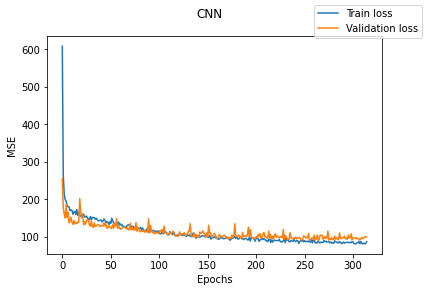

In [ ]:
import matplotlib.pyplot as plt

#fig, axes = plt.subplots(2, 2, sharex=True, sharey=True,figsize=(22,12))
#ax1, ax2 = axes[0]
#ax3, ax4 = axes[1]

fig = plt.figure()
plt.plot(cnn_history.history['loss'], label='Train loss')
plt.plot(cnn_history.history['val_loss'], label='Validation loss')
fig.legend()
fig.suptitle('CNN')
plt.xlabel("Epochs")
plt.ylabel("MSE")

plt.show()